In [406]:
# ===============================
# 1. Imports
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [431]:
import os
import matplotlib.pyplot as plt

FIGURES_DIR = "../figures"
os.makedirs(FIGURES_DIR, exist_ok=True)

def save_plot(filename):
    path = os.path.join(FIGURES_DIR, filename)
    plt.savefig(path, dpi=300, bbox_inches="tight")
    print(f"Saved → {path}")


In [407]:
# ===============================
# 2. Create timeline (days to departure)
# ===============================
days = pd.DataFrame({
    "days_to_departure": np.arange(90, 0, -1)
})

sailing_date = pd.to_datetime("2026-01-19")
days["date"] = sailing_date - pd.to_timedelta(days["days_to_departure"], unit="D")


In [408]:
# ===============================
# 3. Define cabin products
# ===============================
cabins = pd.DataFrame({
    "cabin_type": ["Interior", "Outside", "Balcony"],
    "total_inventory": [300, 200, 100],
    "base_price": [250, 350, 500]
})


In [409]:
# ===============================
# 4. Cross join: time × product
# ===============================
df = days.merge(cabins, how="cross")


In [410]:
# ===============================
# 5. Demand index (urgency effect)
# ===============================
np.random.seed(123)

df["demand_index"] = (
    np.exp(-df["days_to_departure"] / 30)
    * np.random.normal(1.0, 0.1, len(df))
).clip(lower=0)


In [411]:
# ===============================
# 6. Price elasticity by cabin
# ===============================
elasticity_map = {
    "Interior": 1.4,
    "Outside": 1.2,
    "Balcony": 0.9
}

df["elasticity"] = df["cabin_type"].map(elasticity_map)


In [412]:
# ===============================
# 7. Daily price noise
# ===============================
df["daily_shock"] = np.random.normal(0, 0.04, len(df))


In [413]:
# ===============================
# 8. Inventory pressure (late booking window)
# ===============================
df["inventory_pressure"] = np.where(
    df["days_to_departure"] < 21,
    0.08,
    0.0
)


In [414]:
# ===============================
# 9. Raw price calculation
# ===============================
raw_price = (
    df["base_price"]
    * (1 + df["demand_index"] * df["elasticity"])
    * (1 + df["daily_shock"])
    * (1 + df["inventory_pressure"])
)


In [415]:
# ===============================
# 10. Price bounds
# ===============================
price_bounds = {
    "Interior": (250, 600),
    "Outside": (320, 750),
    "Balcony": (450, 1000)
}

df[["price_floor", "price_cap"]] = df["cabin_type"].apply(
    lambda x: pd.Series(price_bounds[x])
)


In [416]:
# ===============================
# 11. Final price + smoothing
# ===============================
df["price"] = (
    raw_price
    .clip(lower=df["price_floor"], upper=df["price_cap"])
    .round(0)
)

df = df.sort_values(["cabin_type", "days_to_departure"])

df["price"] = (
    df.groupby("cabin_type")["price"]
      .rolling(window=3, min_periods=1)
      .mean()
      .reset_index(level=0, drop=True)
      .round(0)
)


In [417]:
# ===============================
# 12. Booking simulation
# ===============================
base_demand = {
    "Interior": 5,
    "Outside": 3,
    "Balcony": 1.5
}

# daily demand volatility
df["demand_shock"] = np.random.lognormal(mean=0, sigma=0.35, size=len(df))


def simulate_one_cabin(g):
    g = g.sort_values("days_to_departure", ascending=False).copy()

    remaining = int(g["total_inventory"].iloc[0])
    bookings = []
    remaining_inventory = []

    for _, row in g.iterrows():
        demand = base_demand[row["cabin_type"]]
        price_ratio = (row["price"] / row["base_price"]) - 1
        price_effect = np.exp(-row["elasticity"] * price_ratio)

        expected_bookings = max(
            demand * price_effect * row["demand_shock"],
            0
        )

        booked = int(np.random.poisson(expected_bookings))
        booked = min(booked, remaining)

        bookings.append(booked)
        remaining_inventory.append(remaining)

        remaining -= booked

    g["bookings"] = bookings
    g["remaining_inventory"] = remaining_inventory
    g["daily_revenue"] = g["bookings"] * g["price"]
    g["cumulative_revenue"] = g["daily_revenue"].cumsum()

    return g


df = df.groupby("cabin_type", group_keys=False).apply(simulate_one_cabin)


/var/folders/z2/nqrvw2956m7fq60mbs3bnl5c0000gn/T/ipykernel_35818/884659271.py:47: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("cabin_type", group_keys=False).apply(simulate_one_cabin)


In [418]:
# ===============================
# 13. Final sorting (day-first view)
# ===============================
df = df.sort_values("days_to_departure", ascending=False).reset_index(drop=True)


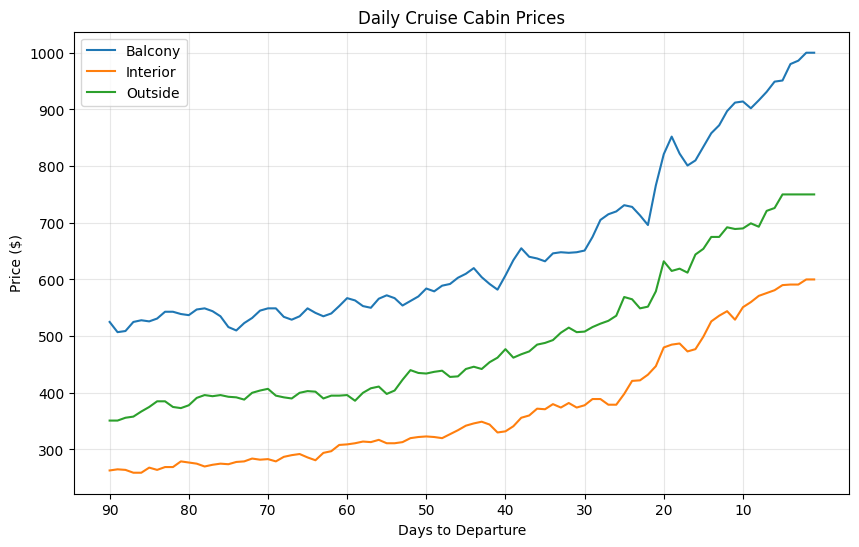

In [419]:
# ===============================
# 14. Plots
# ===============================
price_matrix = (
    df.groupby(["days_to_departure", "cabin_type"], as_index=False)
      .agg(price=("price", "mean"))
      .pivot(
          index="days_to_departure",
          columns="cabin_type",
          values="price"
      )
      .sort_index()
)

plt.figure(figsize=(10, 6))

for cabin in price_matrix.columns:
    plt.plot(price_matrix.index, price_matrix[cabin], label=cabin)

ticks = list(range(
    int(price_matrix.index.max()),
    int(price_matrix.index.min()) - 1,
    -10
))

plt.xticks(ticks)
plt.gca().invert_xaxis()
plt.xlabel("Days to Departure")
plt.ylabel("Price ($)")
plt.title("Daily Cruise Cabin Prices")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [420]:
df["pct_sold"] = (
    (1 - df["remaining_inventory"] / df["total_inventory"]
) * 100).round(1)


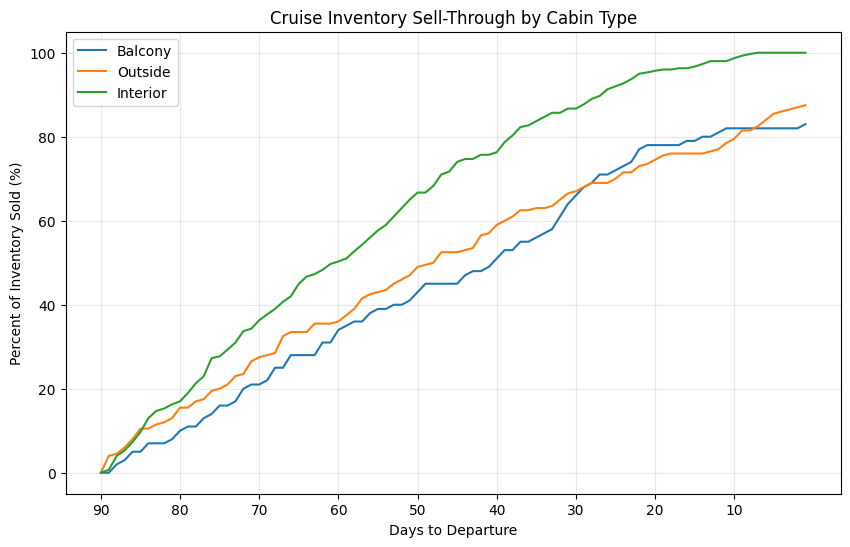

In [421]:
plt.figure(figsize=(10, 6))

for cabin in df["cabin_type"].unique():
    subset = df[df["cabin_type"] == cabin]
    plt.plot(
        subset["days_to_departure"],
        subset["pct_sold"],
        label=cabin
    )

# x-axis formatting
ticks = list(range(
    df["days_to_departure"].max(),
    df["days_to_departure"].min() - 1,
    -10
))

plt.xticks(ticks)
plt.gca().invert_xaxis()

plt.xlabel("Days to Departure")
plt.ylabel("Percent of Inventory Sold (%)")
plt.title("Cruise Inventory Sell-Through by Cabin Type")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [422]:
analysis_df = df.sort_values(
    ["cabin_type", "days_to_departure"],
    ascending=[True, False]
).copy()


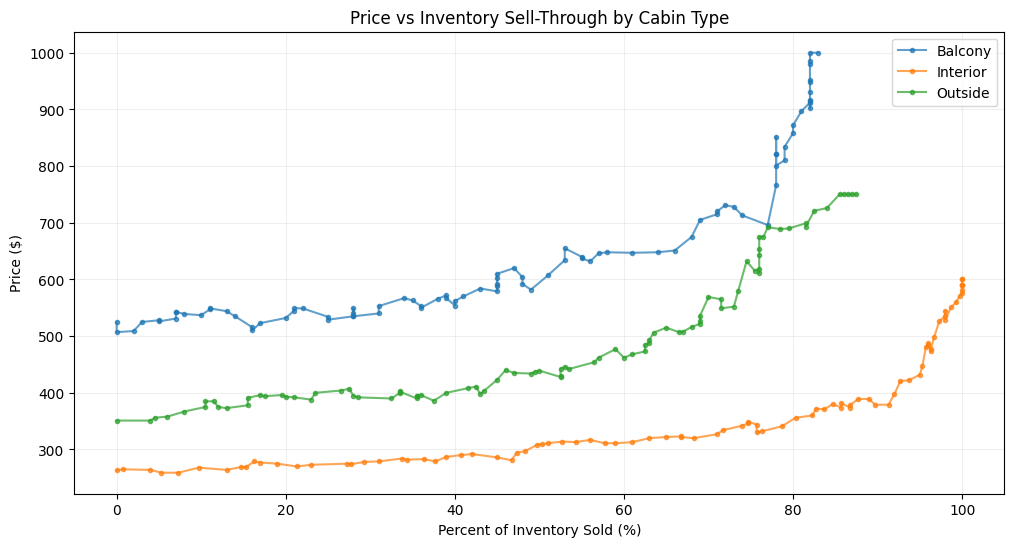

In [423]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for cabin in analysis_df["cabin_type"].unique():
    subset = analysis_df[analysis_df["cabin_type"] == cabin]
    plt.plot(
        subset["pct_sold"],
        subset["price"],
        marker=".",
        alpha=0.7,
        label=cabin
    )
plt.xlabel("Percent of Inventory Sold (%)")
plt.ylabel("Price ($)")
plt.title("Price vs Inventory Sell-Through by Cabin Type")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

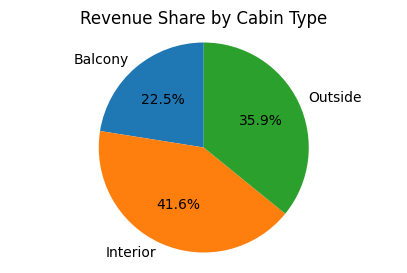

,cabin_type,daily_revenue,revenue_share_pct
0,Balcony,51407.0,22.5
1,Interior,95200.0,41.6
2,Outside,81967.0,35.9


In [424]:
revenue_by_cabin = (
    df.groupby("cabin_type")["daily_revenue"]
      .sum()
      .reset_index()
)

plt.figure(figsize=(5, 3))

plt.pie(
    revenue_by_cabin["daily_revenue"],
    labels=revenue_by_cabin["cabin_type"],
    autopct="%1.1f%%",
    startangle=90
)

plt.title("Revenue Share by Cabin Type")
plt.axis("equal")  # keeps pie circular
plt.show()

revenue_by_cabin["revenue_share_pct"] = (
    revenue_by_cabin["daily_revenue"]
    / revenue_by_cabin["daily_revenue"].sum()
    * 100
).round(1)

revenue_by_cabin



In [425]:
plot_df = (
    df.sort_values("price")
      .reset_index(drop=True)
)


In [426]:
plot_df["avg_bookings"] = (
    plot_df.groupby("cabin_type")["bookings"]
           .rolling(window=25, min_periods=10)
           .mean()
           .reset_index(level=0, drop=True)
)

plot_df["normalized_bookings"] = (
    plot_df.groupby("cabin_type")["avg_bookings"]
           .transform(lambda x: x / x.max())
)



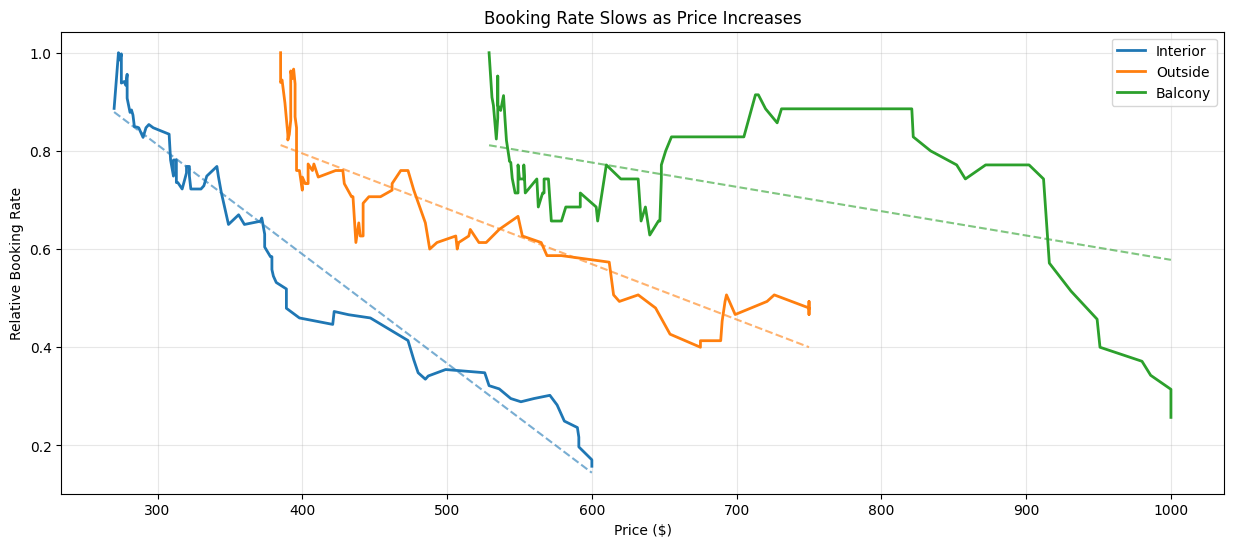

In [427]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

for cabin in plot_df["cabin_type"].unique():
    subset = plot_df[
        (plot_df["cabin_type"] == cabin) &
        (plot_df["normalized_bookings"].notna())
    ]

    # Solid line
    line, = plt.plot(
        subset["price"],
        subset["normalized_bookings"],
        linewidth=2,
        label=cabin
    )

    # Dotted trend line (same color)
    z = np.polyfit(subset["price"], subset["normalized_bookings"], 1)
    p = np.poly1d(z)

    x_vals = np.linspace(
        subset["price"].min(),
        subset["price"].max(),
        100
    )

    plt.plot(
        x_vals,
        p(x_vals),
        linestyle="--",
        color=line.get_color(),  # 👈 key line
        alpha=0.6
    )

plt.xlabel("Price ($)")
plt.ylabel("Relative Booking Rate")
plt.title("Booking Rate Slows as Price Increases")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [428]:
df.head(10)

,days_to_departure,date,cabin_type,total_inventory,base_price,demand_index,elasticity,daily_shock,inventory_pressure,price_floor,price_cap,price,demand_shock,bookings,remaining_inventory,daily_revenue,cumulative_revenue,pct_sold
0,90,2025-10-21,Balcony,100,500,0.051196,0.9,0.056335,0.0,450,1000,525.0,2.004445,0,100,0.0,0.0,0.0
1,90,2025-10-21,Outside,200,350,0.054753,1.2,-0.053060,0.0,320,750,351.0,1.918507,8,200,2808.0,2808.0,0.0
2,90,2025-10-21,Interior,300,250,0.044382,1.4,-0.048535,0.0,250,600,263.0,1.055716,2,300,526.0,526.0,0.0
3,89,2025-10-22,Interior,300,250,0.043721,1.4,-0.024348,0.0,250,600,265.0,1.111212,10,298,2650.0,3176.0,0.7
4,89,2025-10-22,Outside,200,350,0.048496,1.2,-0.052824,0.0,320,750,351.0,0.925795,1,192,351.0,3159.0,4.0
5,89,2025-10-22,Balcony,100,500,0.059975,0.9,-0.026785,0.0,450,1000,507.0,0.949090,2,100,1014.0,1014.0,0.0
6,88,2025-10-23,Outside,200,350,0.050937,1.2,-0.056809,0.0,320,750,356.0,0.835283,3,191,1068.0,4227.0,4.5
7,88,2025-10-23,Balcony,100,500,0.059957,0.9,-0.034660,0.0,450,1000,509.0,0.795302,1,98,509.0,1523.0,2.0
8,88,2025-10-23,Interior,300,250,0.040305,1.4,0.050585,0.0,250,600,264.0,0.804180,4,288,1056.0,4232.0,4.0
9,87,2025-10-24,Outside,200,350,0.051288,1.2,-0.050048,0.0,320,750,358.0,1.189239,4,188,1432.0,5659.0,6.0


In [429]:
# ===============================
# 17. Save final dataset
# ===============================
df.to_csv("../data/processed/cruise_pricing_with_bookings.csv", index=False)


In [434]:
import os
import numpy as np
import matplotlib.pyplot as plt

FIGURES_DIR = "../figures"
os.makedirs(FIGURES_DIR, exist_ok=True)



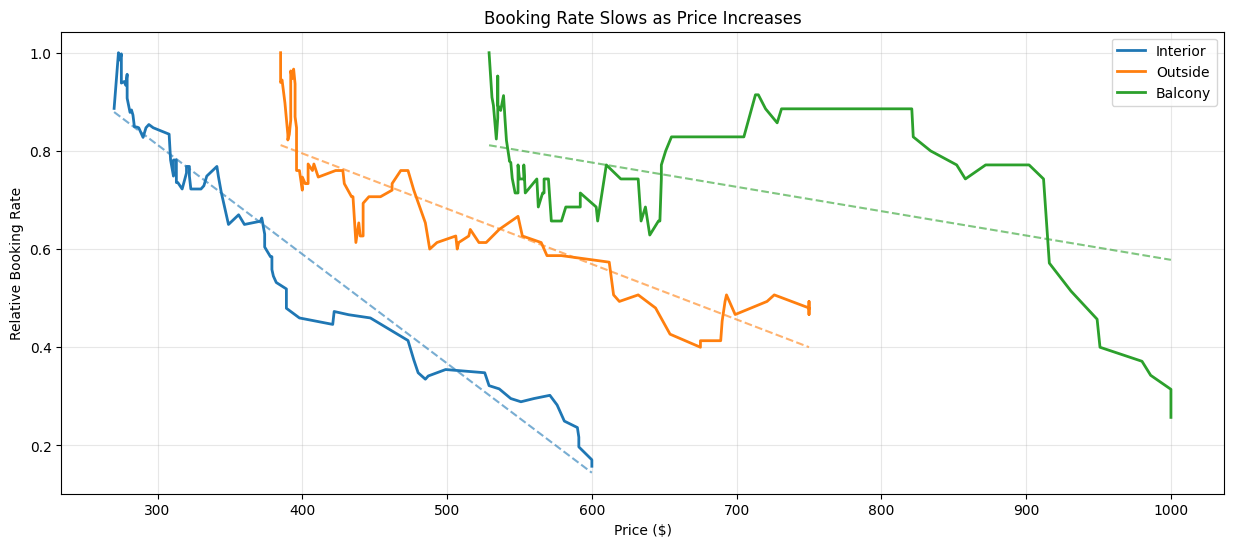

In [435]:
fig, ax = plt.subplots(figsize=(15, 6))

for cabin in plot_df["cabin_type"].unique():
    subset = plot_df[
        (plot_df["cabin_type"] == cabin) &
        (plot_df["normalized_bookings"].notna())
    ]

    line, = ax.plot(
        subset["price"],
        subset["normalized_bookings"],
        linewidth=2,
        label=cabin
    )

    z = np.polyfit(subset["price"], subset["normalized_bookings"], 1)
    p = np.poly1d(z)

    x_vals = np.linspace(
        subset["price"].min(),
        subset["price"].max(),
        100
    )

    ax.plot(
        x_vals,
        p(x_vals),
        linestyle="--",
        color=line.get_color(),
        alpha=0.6
    )

ax.set_xlabel("Price ($)")
ax.set_ylabel("Relative Booking Rate")
ax.set_title("Booking Rate Slows as Price Increases")
ax.legend()
ax.grid(alpha=0.3)

fig.savefig(
    os.path.join(FIGURES_DIR, "01_booking_rate_vs_price.png"),
    dpi=300,
    bbox_inches="tight"
)

plt.show()
plt.close(fig)


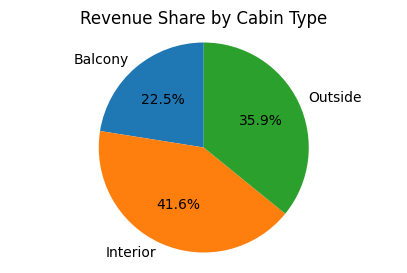

In [436]:
fig, ax = plt.subplots(figsize=(5, 3))

ax.pie(
    revenue_by_cabin["daily_revenue"],
    labels=revenue_by_cabin["cabin_type"],
    autopct="%1.1f%%",
    startangle=90
)

ax.set_title("Revenue Share by Cabin Type")
ax.axis("equal")

fig.savefig(
    os.path.join(FIGURES_DIR, "02_revenue_share_by_cabin.png"),
    dpi=300,
    bbox_inches="tight"
)

plt.show()
plt.close(fig)


In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

for cabin in analysis_df["cabin_type"].unique():
    subset = analysis_df[analysis_df["cabin_type"] == cabin]
    ax.plot(
        subset["pct_sold"],
        subset["price"],
        marker=".",
        alpha=0.7,
        label=cabin
    )

ax.set_xlabel("Percent of Inventory Sold (%)")
ax.set_ylabel("Price ($)")
ax.set_title("Price vs Inventory Sell-Through by Cabin Type")
ax.legend()
ax.grid(alpha=0.2)

fig.savefig(
    os.path.join(FIGURES_DIR, "03_price_vs_sell_through.png"),
    dpi=300,
    bbox_inches="tight"
)

plt.show()
plt.close(fig)
